# Modeling
In this exercise, we will predict activity on Cytochrome P450 ligands. We will use regresion forms of [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) and [Random Forest](https://en.wikipedia.org/wiki/Random_forest). We will use again scikit [SVR](https://scikit-learn.org/stable/modules/svm.html#regression) and [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor).

## Goals of the exercise
* Familiarize yourself with modeling. If mentioned models in this exercise are not enough, you can surely find more methods in scikit-learn. You can use another descriptors, e.g. fingerprints.
* Find some well predictig solution set of model and descriptors on your data

### Loading modules and functions

In [1]:
# loading moduiles and packages
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

RDKit WARNING: [20:56:29] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# functions and variables used in the exercise
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None
    
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error cytochrome P450: {(res[res["Source"]=="Cytochrome P450"]["Prediction"]-res[res["Source"]=="Cytochrome P450"][predicted_value]).abs().mean()}""")
    return res

### Data loading and preprocessing

In [3]:
## Data loading 
with open("Cytochrome_P450_targets.csv") as inp:
    cytc = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in cytc:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol)
            m["source"] = "Cytochrome P450"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [4]:
%%capture
# same for drugbank
drugbank = []
for m in Chem.SDMolSupplier("../data/drugbank.sdf"):
    if m:
        stdmol = standardize(m)
    else:
        continue    
    if stdmol:
        std_smiles = Chem.MolToSmiles(stdmol)
        drugbank.append({
         "rdmol": m,
         "std_rdmol": stdmol,
         "source": "drugbank",
         "std_smiles": std_smiles,
         "Smiles": Chem.MolToSmiles(m),
         "pChEMBL Value": 0,
         "Standard Value": np.NaN,
         "fps": Chem.GetMorganFingerprintAsBitVect(stdmol, 2, nBits=1024),
         **{f[0]: f[1](stdmol) for f in lip_func}
        })

In [5]:
# create dataframe
df = pd.DataFrame((*drugbank, *[m for m in cytc if m["std_rdmol"]]), columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "pChEMBL Value", *(f[0] for f in lip_func)])
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))]))

In [6]:
df.head(3)

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,pChEMBL Value,HBA,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92b61401c0>,<rdkit.Chem.rdchem.Mol object at 0x7f92b616d850>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.0,29,...,0,0,3,3,0,0,0,0,0,0
1,1,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92b616df80>,<rdkit.Chem.rdchem.Mol object at 0x7f92a3265620>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,0.0,16,...,0,0,4,2,0,0,0,0,2,1
2,2,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,drugbank,<rdkit.Chem.rdchem.Mol object at 0x7f92a3265080>,<rdkit.Chem.rdchem.Mol object at 0x7f92a32633f0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",NaN,0.0,15,...,0,0,1,2,0,0,0,1,0,0


In [7]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

## Support Vector Regression (SVR)

In [8]:
svr = svm.SVR()
svr.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR()

In [9]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["Standard Value", "source"]])
res.columns = ["Prediction", "Standard Value", "Source"]
(res["Prediction"]-res["Standard Value"]).abs().mean()

40301858.68883029

In [10]:
(res[res["Source"]=="Cytochrome P450"]["Prediction"]-res[res["Source"]=="Cytochrome P450"]["Standard Value"]).abs().mean()

11548522.365126135

In [11]:
# Let's use some function to get results, we will have lots of models
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 40301858.68883029
Average error cytochrome P450: 11548522.365126135


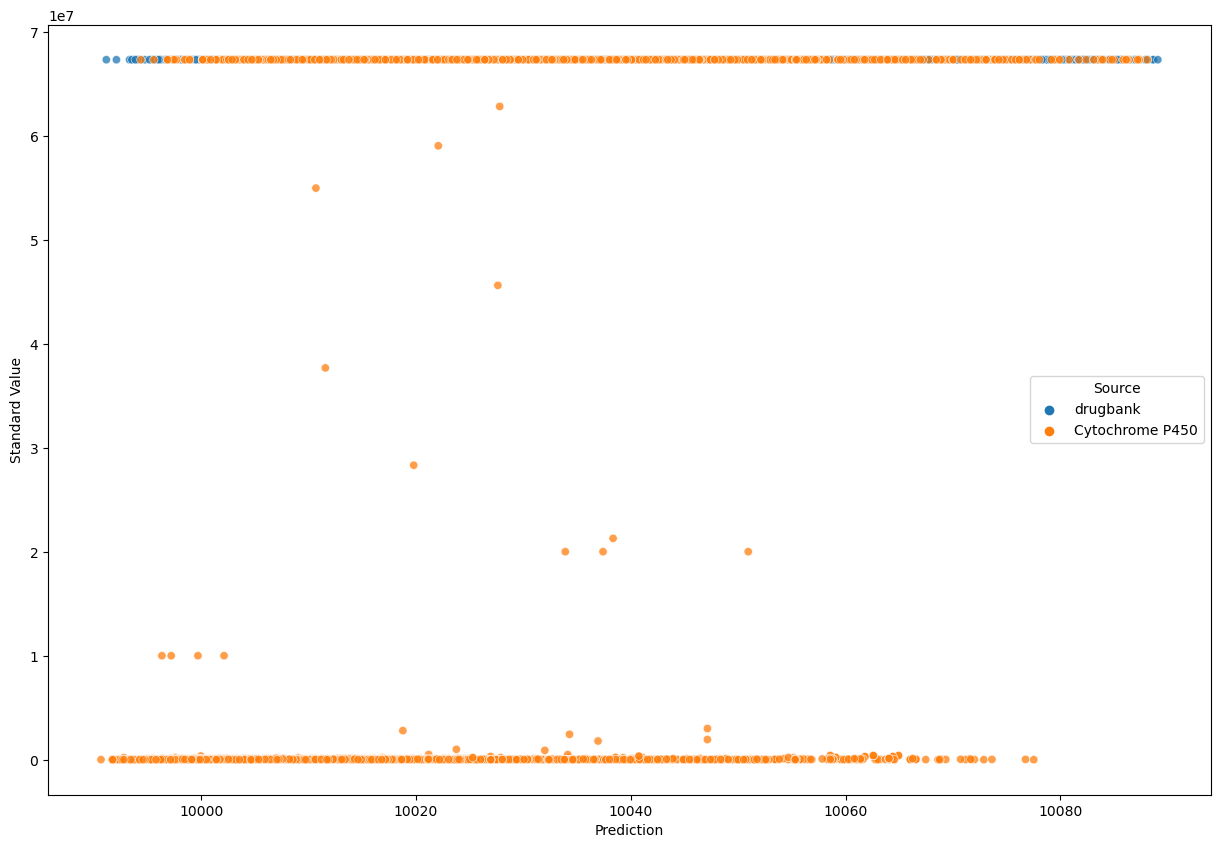

In [12]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

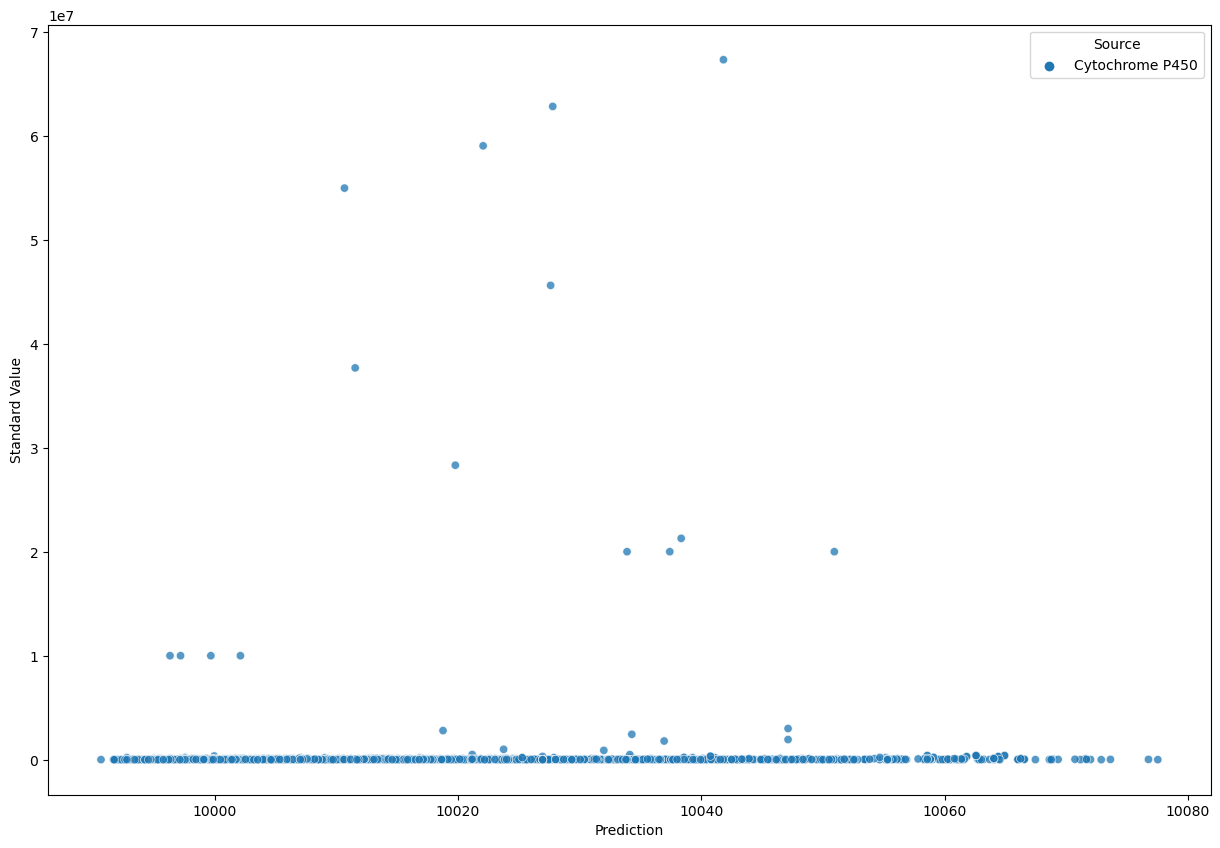

In [13]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

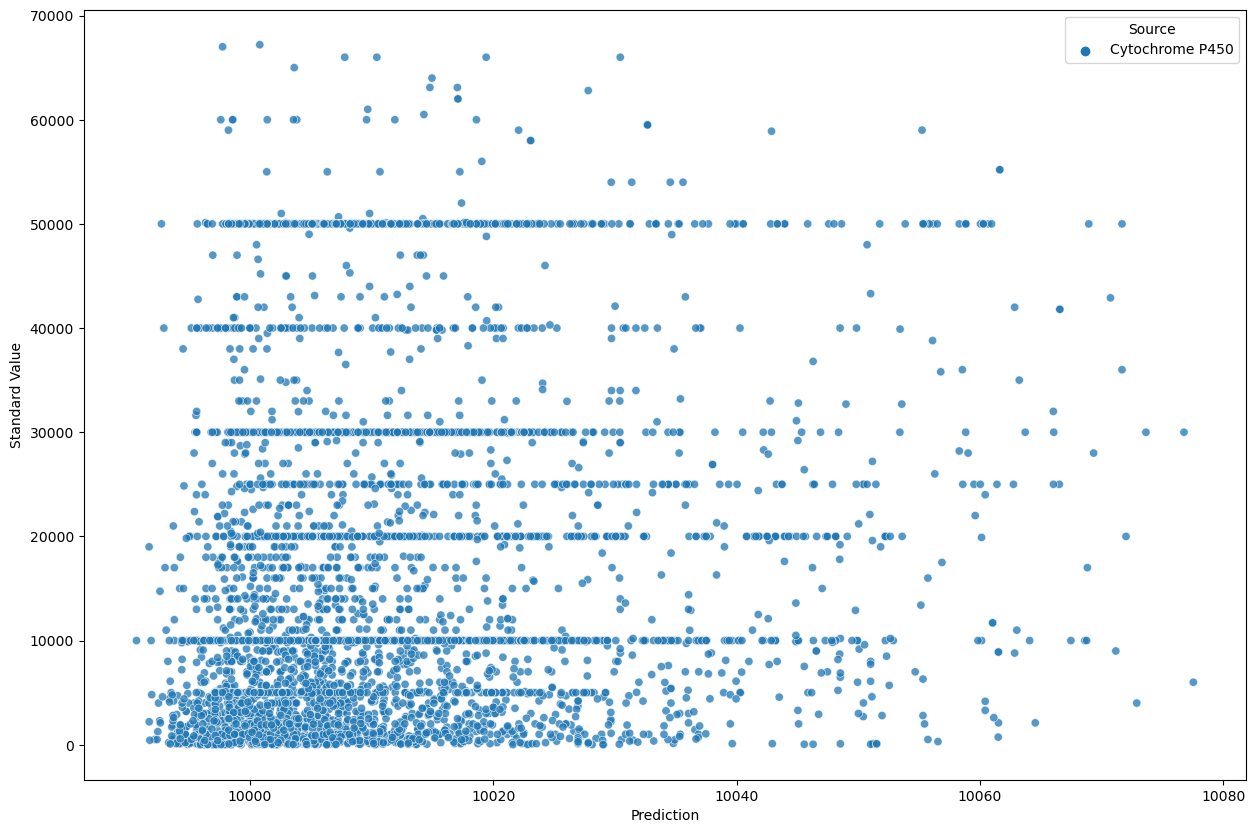

In [14]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res[res["Standard Value"]<mx/1000],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## Random forest

In [15]:
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

RandomForestRegressor()

In [16]:
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "Standard Value")

Average error whole set: 39773068.65852387
Average error cytochrome P450: 11423468.843871621


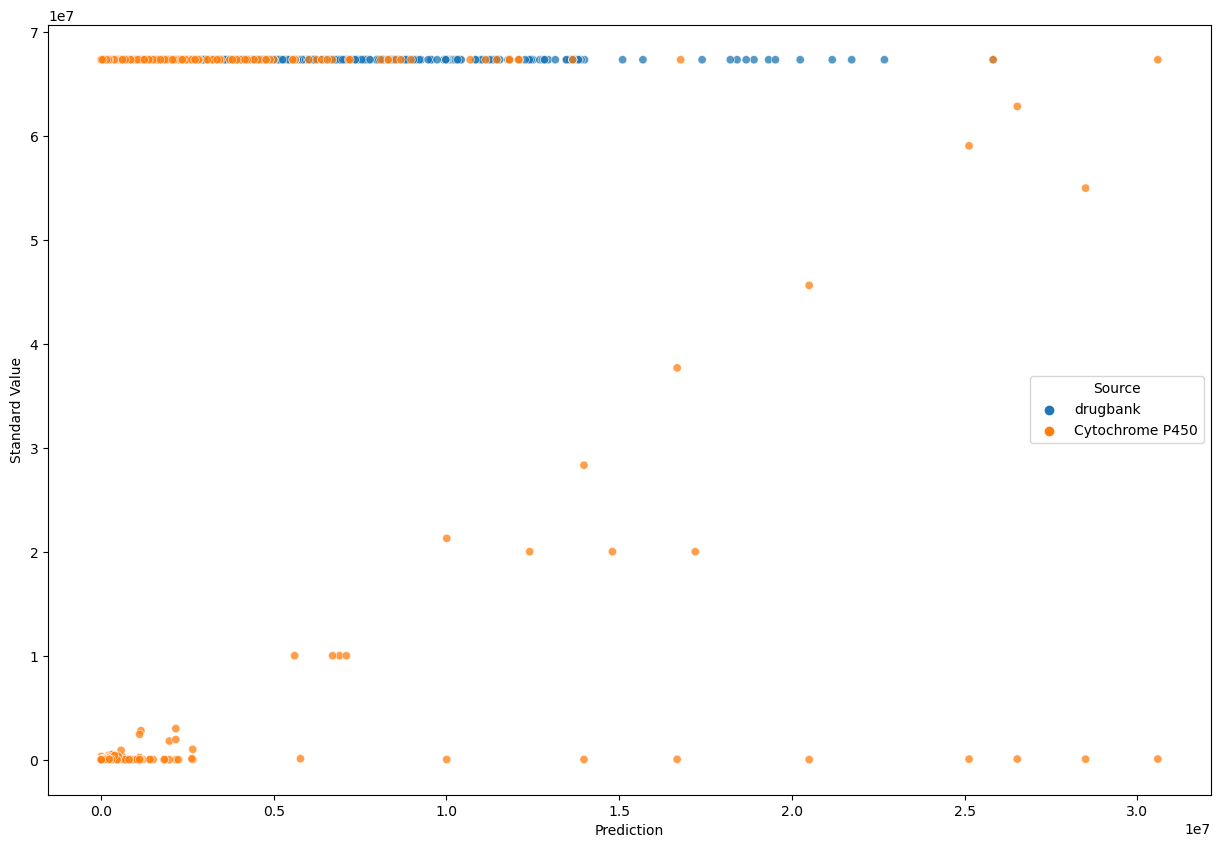

In [17]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

/Users/esimonova/opt/anaconda3/envs/cdd/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


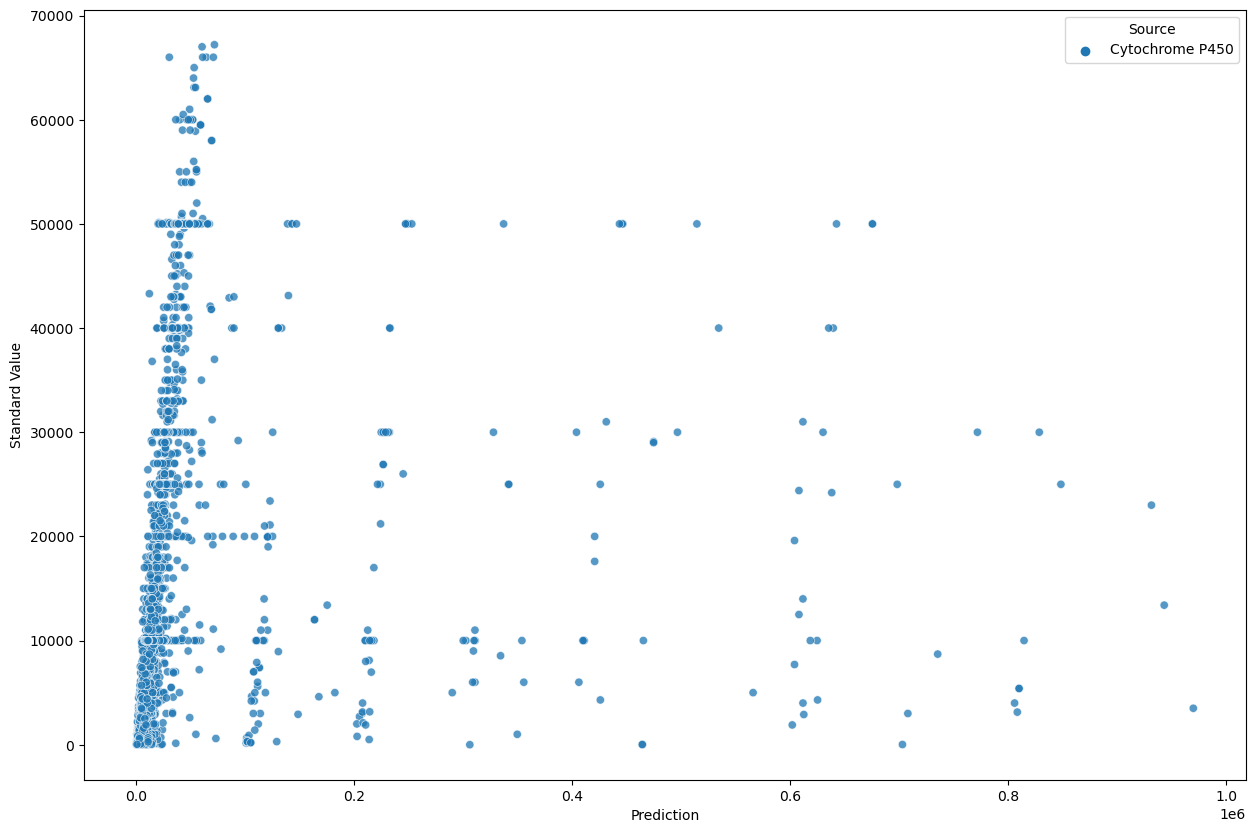

In [18]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="Standard Value",
                      data=res_rf[res_rf["Standard Value"]<mx/1000][res_rf["Prediction"]<1e6],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## SVR

In [19]:
svr_p = svm.SVR()
svr_p.fit(df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR()

In [20]:
res_svr_p = get_results(svr_p, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 4.108365905292381
Average error cytochrome P450: 3.259888032578213


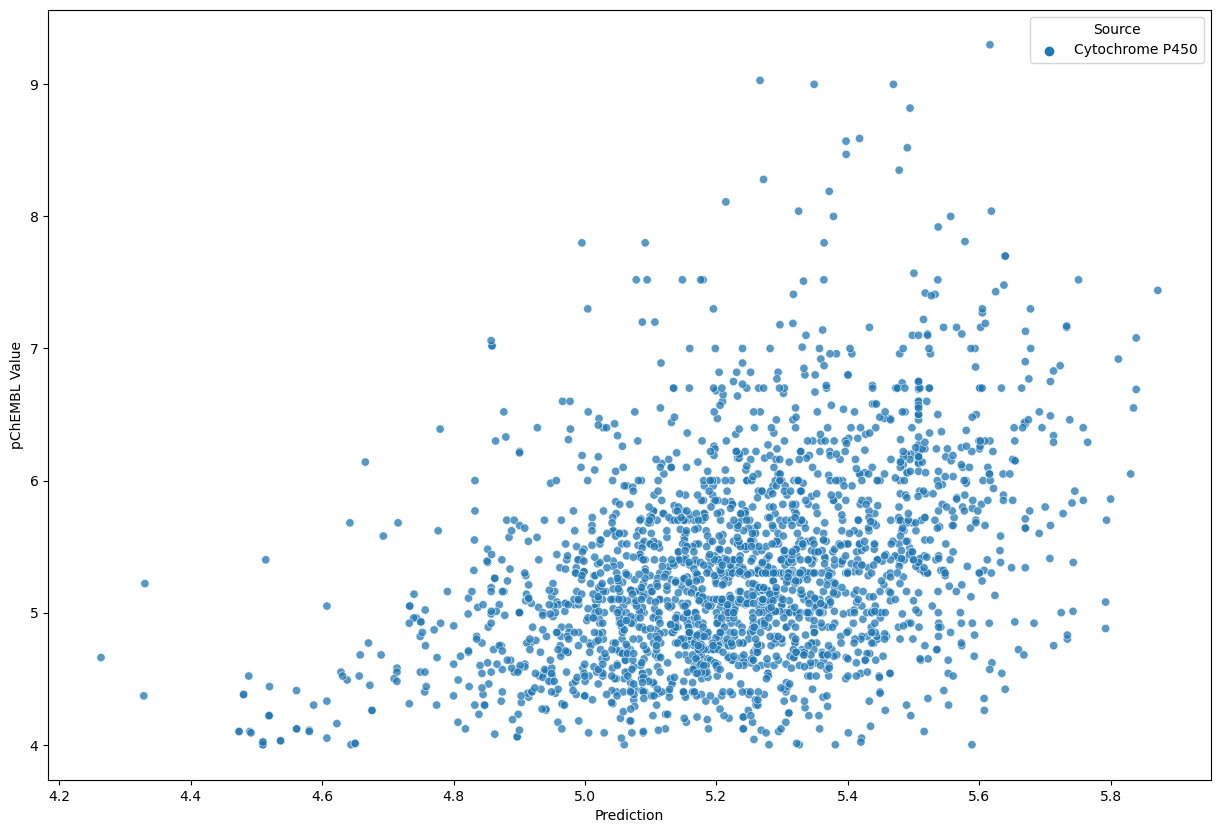

In [21]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## SVR with PCA

In [22]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]),how='left')

In [23]:
svr_np = svm.SVR()
svr_np.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR()

In [24]:
res_svr_np = res = get_results(svr_np, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 1.858442867995865
Average error cytochrome P450: 1.856092976226885


In [25]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75)

As we can see from above, SVR with PCA so far showed the best result. Let's try some other kernels.

In [26]:
# Polynomial
svr_poly = svm.SVR(kernel = 'poly')
svr_poly.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='poly')

In [27]:
res_svr_np = get_results(svr_poly, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 3.5207572369438633
Average error cytochrome P450: 2.257555545177054


In [28]:
# RBF
svr_rbf = svm.SVR(kernel = 'rbf')
svr_rbf.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR()

In [29]:
res_svr_np = get_results(svr_rbf, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 1.858442867995865
Average error cytochrome P450: 1.856092976226885


In [30]:
# Linear
svr_lin = svm.SVR(kernel = 'linear')
svr_lin.fit(df[df["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='linear')

In [31]:
res_svr_np = get_results(svr_lin, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 2.6483619543103742
Average error cytochrome P450: 2.374315247851055


In [32]:
# Sigmoid
svr_np = svm.SVR(kernel='sigmoid')
svr_np.fit(df[df["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df[df["Standard Value"]<mx]["Standard Value"])

SVR(kernel='sigmoid')

In [33]:
res_svr_np = get_results(svr_np, df, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 10056.497652536364
Average error cytochrome P450: 10055.472588584873


We can see that other kernels did not improve the results.

## We need test set
So, we divide our data in some ration (default is 75:25, but 80:20-70:30 is usually OK)

In [34]:
trainset, testset = ms.train_test_split(df[df["pChEMBL Value"]>0])

In [35]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [36]:
len(trainset), len(testset)

(1749, 584)

In [37]:
finaly_good_model = svm.SVR()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

SVR()

In [38]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5295608746823804
Average error cytochrome P450: 0.5295608746823804


In [39]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error whole set: 0.5327716181859926
Average error cytochrome P450: 0.5327716181859926


In [40]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.11
R: 0.34
MSE: 0.53


In [41]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [42]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

## Conclusion

SVR with RBF kernel shows the best performance on my data with the following estimator measures:

* *R^2:* 0.11
* *R:* 0.34
* *MSE:* 0.53
* *Average error whole set:* 1.858
* *Average error cytochrome P450:* 1.856